# Overview

The goal of this exercise is to create a fully worked out F2 edition of the text. F2 refers to Standard Text Analytic Data Model (STADM):

> A normalized set of tables including DOC, TOKEN, and TERM tables. Produced by the tokenization of F1 data. Other tables and columns may be added, such as sentiment and other labels to the DOC table. May be stored in a relational database or stand-alone files (such as CSV). The text form level is similar to so-called "tidy text format' from the R community.	

# Recap

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

In [2]:
BODY_START = 151
BODY_END = 18831
CHAP_PAT = r'^\s*(?:CHAPTER).*$'
PARA_PAT = r'\n\n+'
SENT_PAT = r'([.;?!"“”]+)'
TOKEN_PAT = r'([\W_]+)'
src_file = 'pg730.txt'
    
# Text to lines
lines = open(src_file, 'r', encoding='utf-8').readlines()
lines = lines[BODY_START - 1 : BODY_END + 1]
df = pd.DataFrame({'line_str':lines})
df.index.name = 'line_id'

# Lines to Chapters
mask = df.line_str.str.match(CHAP_PAT)
df.loc[mask, 'chap_id'] = df.apply(lambda x: x.name, 1)
df.chap_id = df.chap_id.ffill().astype('int')
chap_ids = df.chap_id.unique().tolist()
df['chap_num'] = df.chap_id.apply(lambda x: chap_ids.index(x))
chaps = df.groupby('chap_num')\
    .apply(lambda x: ''.join(x.line_str))\
    .to_frame()\
    .rename(columns={0:'chap_str'})

# Chapters to Paragraphs
paras = chaps.chap_str.str.split(PARA_PAT, expand=True)\
    .stack()\
    .to_frame()\
    .rename(columns={0:'para_str'})
paras.index.names = ['chap_num', 'para_num']
paras.para_str = paras.para_str.str.strip()
paras.para_str = paras.para_str.str.replace(r'\n', ' ')
paras.para_str = paras.para_str.str.replace(r'\s+', ' ')
paras = paras[~paras.para_str.str.match(r'^\s*$')]

# Paragraphs to Sentences
sents = paras.para_str.str.split(SENT_PAT, expand=True)\
    .stack()\
    .to_frame()\
    .rename(columns={0:'sent_str'})
sents.index.names = ['chap_num', 'para_num', 'sent_num']

# Sentences to Tokens
tokens = sents.sent_str.str.split(TOKEN_PAT, expand=True)\
    .stack()\
    .to_frame()\
    .rename(columns={0:'token_str'})
tokens.index.names = ['chap_num', 'para_num', 'sent_num', 'token_num']

# Clean up
del(df, lines, chaps, paras, sents, mask)

# Tag punction
tokens['punc'] = tokens.token_str.str.match(r'^\W*$').astype('int')

In [3]:
tokens

token_str  punc
chap_num para_num sent_num token_num                     
0        0        0        0                CHAPTER     0
                           1                            1
                           2                      I     0
         1        0        0                 TREATS     0
                           1                            1
                           2                     OF     0
                           3                            1
                           4                    THE     0
                           5                            1
                           6                  PLACE     0
                           7                            1
                           8                  WHERE     0
                           9                            1
                           10                OLIVER     0
                           11                           1
                           12                 TWIST     0
                           13                           1
                           14                   WAS     0
                           15                           1
                           16                  BORN     0
                           17                           1
                           18                   AND     0
                           19                           1
                           20                    OF     0
                           21                           1
                           22                   THE     0
                           23                           1
                           24         CIRCUMSTANCES     0
                           25                           1
                           26             ATTENDING     0
...                                             ...   ...
52       17       8        13                           1
                           14               because     0
                           15                           1
                           16                  that     0
                           17                           1
                           18                  nook     0
                           19                           1
                           20                    is     0
                           21                           1
                           22                    in     0
                           23                           1
                           24                     a     0
                           25                           1
                           26                Church     0
                           27                    ,      1
                           28                   and     0
                           29                           1
                           30                   she     0
                           31                           1
                           32                   was     0
                           33                           1
                           34                  weak     0
                           35                           1
                           36                   and     0
                           37                           1
                           38                erring     0
                  9        0                            1
                           1                      .     1
                           2                            1
                  10       0                            1

[380550 rows x 2 columns]

# Explore

## Now get paragraphs and chapters back

In [89]:
paras2 = tokens.groupby(['chap_num','para_num']).token_str.apply(lambda x: ''.join(x))\
    .to_frame()\
    .rename(columns={'token_str':'para_str'})

In [90]:
chaps2 = paras2.groupby(['chap_num']).para_str.apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'para_str':'chap_str'})

## Define function to recreate OHCO chunks

In [91]:
def gather_chunks(df, div_names, doc_str = 'token_str', sep=''):
    chunks = df.groupby(div_names)[doc_str].apply(lambda x: x.str.cat(sep=sep))
    chunks.columns = ['doc_content']
    return chunks.to_frame()

In [92]:
# chaps = gather_chunks(tokens, ['chap_num'], sep=' ')
# paras = gather_chunks(tokens, ['chap_num', 'para_num'], sep='')
# sents = gather_chunks(tokens, ['chap_num', 'para_num', 'sent_num'])

## View non-puncuation token counts

In [93]:
token_counts = tokens[tokens.punc == 0].token_str.str.lower().value_counts()

In [94]:
token_counts.head(2|5)

the    40666
of     19702
and    14836
a      14442
to     13825
in     11098
he      9637
Name: token_str, dtype: int64

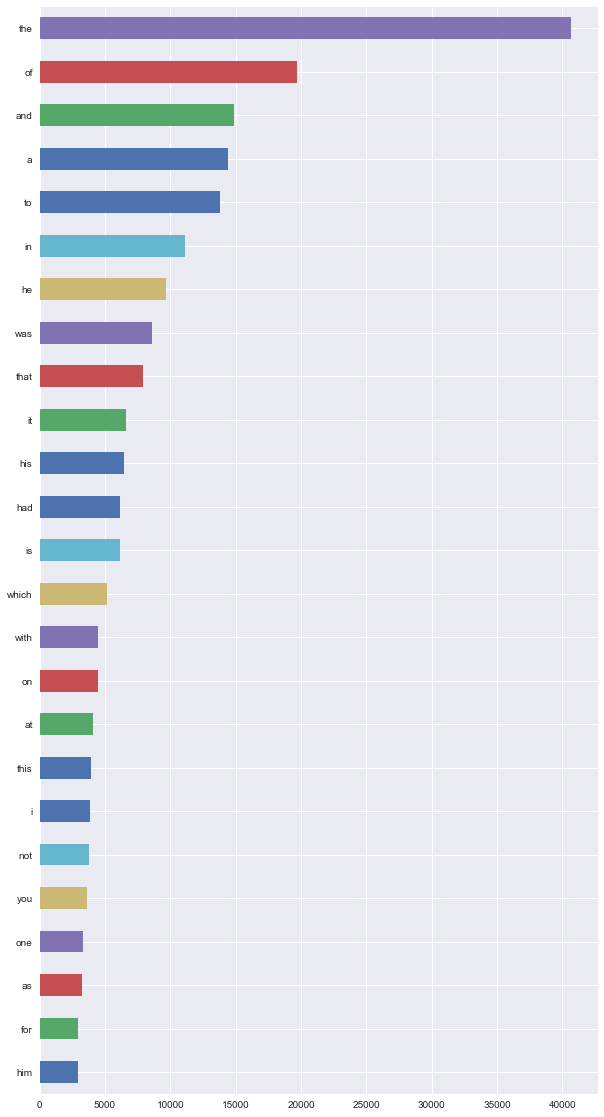

In [95]:
token_counts.head(25).sort_values().plot(kind='barh', figsize=(10,20))

## Save Tokens dataframe to file

In [10]:
tokens.to_csv('moby-tokens.csv')

# Create Vocabulary table

In [96]:
tokens.loc[tokens.punc == 0, 'term_str'] = tokens.token_str.str.lower()

In [97]:
vocab = tokens[tokens.punc == 0].term_str.value_counts().to_frame()\
    .reset_index()\
    .rename(columns={'index':'term_str', 'term_str':'n'})
vocab = vocab.sort_values('term_str').reset_index()
vocab.index.name = 'term_id'
vocab = vocab.drop('index', 1)

In [98]:
vocab

,term_str,n
term_id,,
0,(_,10
1,[_,9
2,_,747
3,_,8
4,_ (_,1
5,_ [,1
6,'_,1
7,'_,1
8,) [ _,2


## Show top 25 terms

In [99]:
vocab.sort_values('n', ascending=False).head(25)

,term_str,n
term_id,,
20671,the,40666
14394,of,19702
1015,and,14836
265,a,14442
20946,to,13825
10798,in,11098
10024,he,9637
22469,was,8617
20667,that,7900


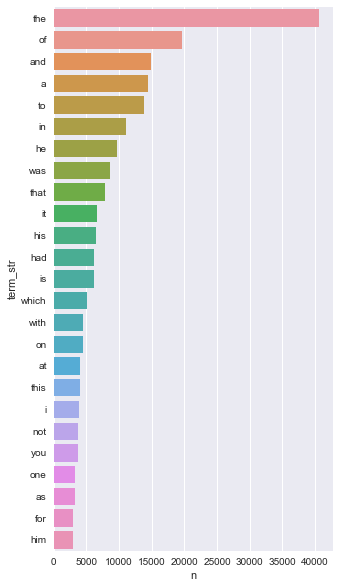

In [100]:
top_terms = vocab.sort_values('n', ascending=False).head(25)
plt.figure(figsize=(5,10))
sns.barplot(data=top_terms, y='term_str', x='n', orient='h')
plt.show()

## Add term ID to tokens

In [101]:
tokens['term_id'] = tokens['term_str'].map(vocab.reset_index().set_index('term_str').term_id).fillna(-1).astype('int')
# tokens.term_id = tokens.term_id.astype('int')

In [102]:
tokens[tokens.punc == 0].sort_values('term_id').sample(10)

,,,,token_str,punc,term_str,term_id
chap_num,para_num,sent_num,token_num,,,,
13,2,8,12,cause,0,cause,3567
171,6,4,6,was,0,was,22469
200,10,4,22,work,0,work,22815
293,25,4,46,say,0,say,18276
220,14,4,16,to,0,to,20946
283,272,2,6,were,0,were,22591
276,26,4,32,to,0,to,20946
173,1,14,40,with,0,with,22767
306,11,14,14,Guardsmen,0,guardsmen,9736


In [4]:

df = pd.DataFrame(tokens.index.get_level_values('para_num'))
df['para_num'] = pd.DataFrame(tokens.index.get_level_values('para_num'))
df['chap_num'] = pd.DataFrame(tokens.index.get_level_values('chap_num'))
groups = pd.DataFrame(df.groupby("chap_num")['para_num'].max())
#df
groups

,para_num
chap_num,
0,19
1,78
2,75
3,64
4,90
5,35
6,61
7,57
8,57


In [5]:
groups.para_num.sum()

3901

In [57]:
tokens.sort_index(level='para_num', ascending=False)

token_str  punc   term_str  term_id
chap_num para_num sent_num token_num                                     
54       112      16       0                        1        NaN       -1
                  15       2                        1        NaN       -1
                           1                  ”     1        NaN       -1
                           0                        1        NaN       -1
                  14       2                        1        NaN       -1
                           1                  ’     1        NaN       -1
                           0                        1        NaN       -1
                  13       2                        1        NaN       -1
                           1                  .     1        NaN       -1
                           0                        1        NaN       -1
                  12       24            Radney     0     radney    11925
                           23                       1        NaN       -1
                           22                of     0         of    10248
                           21                       1        NaN       -1
                           20             death     0      death     3912
                           19                       1        NaN       -1
                           18               the     0        the    15057
                           17                       1        NaN       -1
                           16             since     0      since    13495
                           15                       1        NaN       -1
                           14         Steelkilt     0  steelkilt    14243
                           13                       1        NaN       -1
                           12              with     0       with    16926
                           11                       1        NaN       -1
                           10            talked     0     talked    14873
                           9                        1        NaN       -1
                           8                and     0        and      699
                           7                        1        NaN       -1
                           6               seen     0       seen    13089
                           5                        1        NaN       -1
...                                         ...   ...        ...      ...
2        0        2        5                  -     1        NaN       -1
                           4             Carpet     0     carpet     2364
                           3                        1        NaN       -1
                           2                The     0        the    15057
                           1                        1        NaN       -1
                           0                        1        NaN       -1
                  1        2                        1        NaN       -1
                           1                  .     1        NaN       -1
                           0                        1        NaN       -1
                  0        2                  2     0          2       92
                           1                        1        NaN       -1
                           0            CHAPTER     0    chapter     2540
1        0        4        0                        1        NaN       -1
                  3        2                        1        NaN       -1
                           1                  .     1        NaN       -1
                           0                        1        NaN       -1
                  2        2           Loomings     0   loomings     8956
                           1                        1        NaN       -1
                           0                        1        NaN       -1
                  1        2                        1        NaN       -1
                           1                  .     1        NaN       -1
                           0              

## Define convenience functions for vocabulary

In [18]:
def get_term_id(term_str):
    return vocab[vocab.term_str == term_str].index[0]

def get_term_str(term_id):
    return vocab.loc[term_id].term_str

In [19]:
get_term_id('ahab')

522

In [20]:
get_term_str(16729)

'whale'

In [21]:
vocab.loc[16729]

term_str    whale
n            1228
Name: 16729, dtype: object

## Create pure tokens tables

In [22]:
tokens2 = tokens[tokens.term_id >= 0].drop('term_str', axis=1)

## Dispersion Plots, etc.

In [23]:
kahuna = pd.get_dummies(tokens.reset_index()['term_str']).T

In [24]:
kahuna.sample(10)

,0,1,2,3,4,5,6,7,8,9,...,502524,502525,502526,502527,502528,502529,502530,502531,502532,502533
tendon,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
spread,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
wiping,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ll,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
prouder,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
salute,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sporting,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
taste,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tandem,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dodges,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


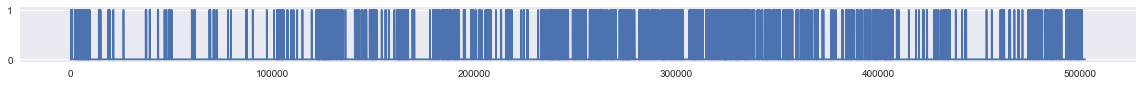

In [25]:
kahuna.loc['whale'].plot(figsize=(20,1))

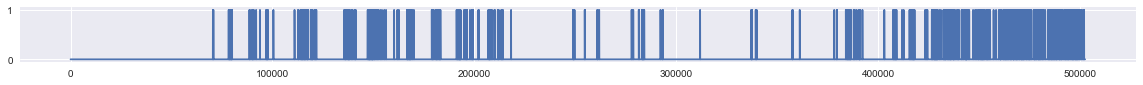

In [26]:
kahuna.loc['ahab'].plot(figsize=(20,1))

In [27]:
terms = ['stubb', 'ahab','whale', 'starbuck', 'queequeg', 'ishmael', 'white', 'sea', 'ship', 'church', 'death']

In [28]:
viz_df = kahuna.loc[terms].T\
  .stack()\
  .to_frame()\
  .reset_index()\
  .rename(columns={'level_0': 't', 'level_1':'term_str', 0:'n'})

In [29]:
viz_df[viz_df.n > 0].sample(5)

,t,term_str,n
1011986,91998,ship,1
1043849,94895,queequeg,1
4889214,444474,stubb,1
2863170,260288,whale,1
536256,48750,white,1


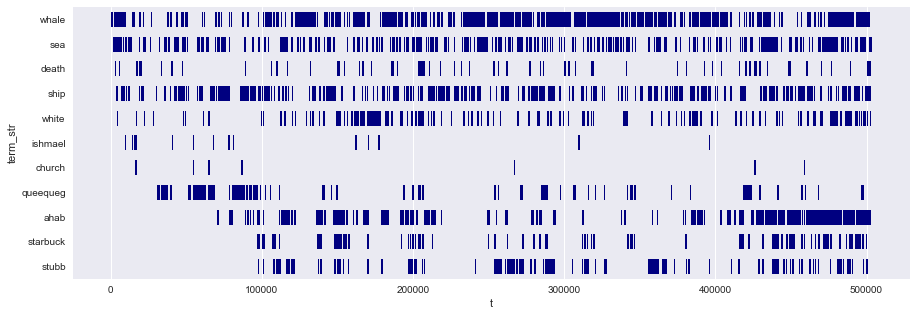

In [30]:
plt.figure(figsize=(15,5))
sp = sns.stripplot(y='term_str', x='t', data=viz_df[viz_df.n == 1],
 orient='h', marker="$|$", color='navy', size=15, jitter=0)
plt.show()

# Experiment -- Can We Detect Stopwords by Entropy?

In [32]:
TDM = tokens[tokens.term_id >= 0].groupby(['chap_num','term_str']).term_str.count().to_frame().unstack().fillna(0.00001).T

In [33]:
TDM = TDM.apply(lambda x: x / x.sum(), 1)

In [34]:
TDH = TDM.apply(lambda x: -(x * np.log2(x))).sum(1).to_frame().rename(columns={0:'H'})

In [35]:
TDH = TDH.reset_index().drop('level_0', 1)

In [36]:
TDH.H.idxmax()

2540

In [37]:
TDH.loc[2540]

term_str    chapter
H           6.82126
Name: 2540, dtype: object

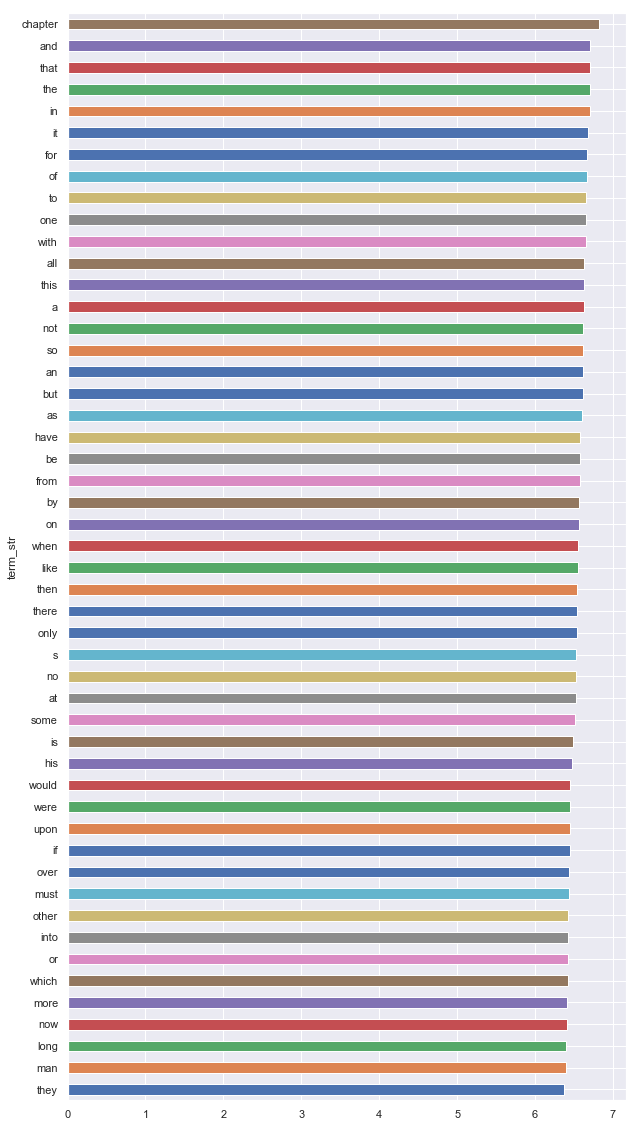

In [38]:
TDH.sort_values('H', ascending=False)\
    .reset_index().set_index('term_str').H\
    .head(50).sort_values().plot(kind='barh', figsize=(10,20))

In [39]:
## Add entropy to Vocabulary

In [40]:
vocab = vocab.merge(TDH, on='term_str', copy=False)

In [41]:
# vocab = vocab.drop(['H_x','H_y'], 1)

In [42]:
vocab.sort_values('H', ascending=False)

,term_str,n,H
2540,chapter,173,6.821259
699,and,6430,6.710230
15055,that,3085,6.708981
15057,the,14430,6.703840
7651,in,4173,6.702097
8188,it,2521,6.682740
5987,for,1617,6.672563
10248,of,6609,6.666222
15287,to,4625,6.658245
10305,one,921,6.648833


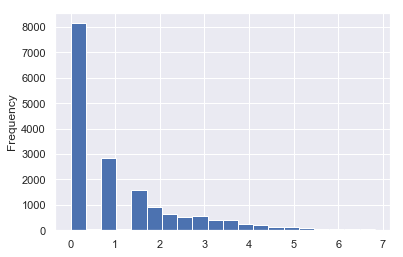

In [43]:
vocab.H.plot.hist(bins=20)

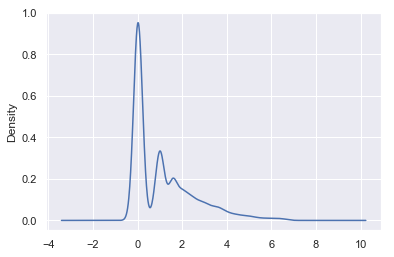

In [44]:
vocab.H.plot.kde()

In [45]:
vocab.H.describe()

count    17159.000000
mean         1.143861
std          1.398616
min          0.000414
25%          0.024519
50%          1.012177
75%          1.926835
max          6.821259
Name: H, dtype: float64

In [46]:
vocab[vocab.H > vocab.H.quantile(.95)].sort_values('H', ascending=False)

,term_str,n,H
2540,chapter,173,6.821259
699,and,6430,6.710230
15055,that,3085,6.708981
15057,the,14430,6.703840
7651,in,4173,6.702097
8188,it,2521,6.682740
5987,for,1617,6.672563
10248,of,6609,6.666222
15287,to,4625,6.658245
10305,one,921,6.648833
